In [234]:
import numpy as np 
import pandas as pd
import os
import sys
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [235]:
BASE_DIR = "../../../data/pc_game"


In [236]:
df_train = pd.read_csv(BASE_DIR + '/train.csv')
df_test = pd.read_csv(BASE_DIR + '/test.csv')
df_sub = pd.read_csv(BASE_DIR + '/sample_submit.csv',header=None)

In [237]:
df_train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [238]:
df_test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


In [239]:
df_sub

,0,1
0,9,0
1,15,0
2,18,0
3,23,0
4,31,0
...,...,...
1995,9971,0
1996,9980,0
1997,9983,0
1998,9996,0


In [240]:
col_li = df_train.columns.tolist()
feature_col = df_test.columns.tolist()
df_train['blueWins'].value_counts()

0    4066
1    3934
Name: blueWins, dtype: int64

In [241]:
df_train.head()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0


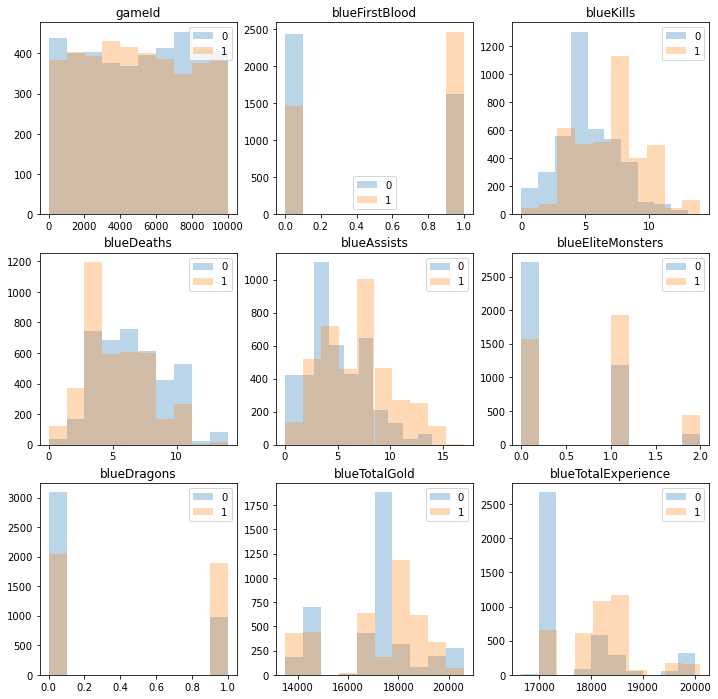

In [242]:
plt.figure(figsize=(12,12))
for i in range(len(feature_col)):
    plt.subplot(3,3,i+1)
    plt.hist(df_train[df_train['blueWins']==0][feature_col[i]],label='0',alpha=0.3)
    plt.hist(df_train[df_train['blueWins']==1][feature_col[i]],label='1',alpha=0.3)
    plt.legend()
    plt.title(feature_col[i])
plt.show()

In [243]:
# trainとtestの分布
#同じ
# plt.figure(figsize=(12,12))
# for i in range(len(feature_col)):
#     plt.subplot(3,3,i+1)
#     plt.hist(df_train[feature_col[i]],label='train',alpha=0.3)
#     plt.hist(df_test[feature_col[i]],label='test',alpha=0.3)
#     plt.legend()
#     plt.title(feature_col[i])
# plt.show()

In [255]:
df_train['blueKills/blueDeath'] = df_train['blueKills'] / (df_train['blueDeaths']+1)
df_test['blueKills/blueDeath'] = df_test['blueKills'] / (df_test['blueDeaths']+1)

df_train['blueKills/blueTotalGold'] = df_train['blueKills'] / (df_train['blueTotalGold'])
df_test['blueKills/blueTotalGold'] = df_test['blueKills'] / (df_test['blueTotalGold'])

df_train['blueKills/blueTotalExperience'] = df_train['blueKills'] / (df_train['blueTotalExperience'])
df_test['blueKills/blueTotalExperience'] = df_test['blueKills'] / (df_test['blueTotalExperience'])

df_train['blueTotalExperience/blueDragons'] = df_train['blueTotalExperience'] / (df_train['blueDragons']+1)
df_test['blueTotalExperience/blueDragons'] = df_test['blueTotalExperience'] / (df_test['blueDragons']+1)

df_train['blueTotalExperience/blueEliteMonsters'] = df_train['blueTotalExperience'] / (df_train['blueEliteMonsters']+1)
df_test['blueTotalExperience/blueEliteMonsters'] = df_test['blueTotalExperience'] / (df_test['blueEliteMonsters']+1)

In [256]:
df_train.groupby('blueDragons')['blueWins'].value_counts()

blueDragons  blueWins
0            0           3093
             1           2042
1            1           1892
             0            973
Name: blueWins, dtype: int64

In [257]:
df_train.corr()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,...,blueKills__blueTotalGold,blueKills__blueTotalExperience,blueDeaths__blueEliteMonsters,blueDeaths__blueDragons,blueDeaths__blueTotalGold,blueDeaths__blueTotalExperience,blueAssists__blueEliteMonsters,blueAssists__blueDragons,blueAssists__blueTotalGold,blueAssists__blueTotalExperience
gameId,1.000000,-0.001356,0.015867,0.011907,0.013440,0.001194,0.001223,0.012690,-0.000432,-0.014944,...,0.005751,0.000188,0.020078,0.003098,0.005429,0.016859,0.020607,0.011758,0.007079,0.014320
blueFirstBlood,-0.001356,1.000000,0.283559,-0.325833,0.241781,0.213862,0.155051,-0.111157,0.033651,0.226536,...,0.518771,0.986580,0.256977,0.251225,0.193875,0.248676,-0.012690,0.077994,0.042358,-0.339312
blueKills,0.015867,0.283559,1.000000,-0.079929,0.710046,0.246184,0.196728,0.099387,0.309264,0.337541,...,0.229627,0.304167,0.854003,0.501073,0.436824,0.969008,0.483009,0.203164,0.166547,-0.056417
blueDeaths,0.011907,-0.325833,-0.079929,1.000000,-0.060368,-0.223138,-0.180798,0.060901,-0.051879,-0.237224,...,-0.250822,-0.322539,-0.069649,-0.203586,-0.164977,-0.063337,0.571058,0.140158,0.131797,0.971305
blueAssists,0.013440,0.241781,0.710046,-0.060368,1.000000,0.213466,0.176668,0.108863,0.301567,0.311647,...,0.206481,0.262276,0.920779,0.371840,0.334509,0.701885,0.714319,0.178424,0.150155,-0.035507
blueEliteMonsters,0.001194,0.213862,0.246184,-0.223138,0.213466,1.000000,0.787022,0.149436,0.295139,0.272810,...,0.599715,0.235712,0.227293,0.896441,0.724723,0.268670,0.015374,0.843031,0.657960,-0.181321
blueDragons,0.001223,0.155051,0.196728,-0.180798,0.176668,0.787022,1.000000,0.185465,0.295516,0.251957,...,0.712816,0.180789,0.188668,0.692951,0.899805,0.231354,0.020008,0.675804,0.860919,-0.133731
blueTotalGold,0.012690,-0.111157,0.099387,0.060901,0.108863,0.149436,0.185465,1.000000,0.162229,0.040489,...,0.094047,0.016132,0.141599,0.162983,0.196549,0.325994,0.110890,0.158872,0.184026,0.274516
blueTotalExperience,-0.000432,0.033651,0.309264,-0.051879,0.301567,0.295139,0.295516,0.162229,1.000000,0.328167,...,0.166639,0.061180,0.304317,0.287917,0.290356,0.330050,0.212421,0.276346,0.273605,-0.016271
blueWins,-0.014944,0.226536,0.337541,-0.237224,0.311647,0.272810,0.251957,0.040489,0.328167,1.000000,...,0.251385,0.240220,0.330790,0.320334,0.302070,0.335879,0.085567,0.175989,0.164452,-0.219119


In [258]:
df_train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,...,blueKills__blueTotalGold,blueKills__blueTotalExperience,blueDeaths__blueEliteMonsters,blueDeaths__blueDragons,blueDeaths__blueTotalGold,blueDeaths__blueTotalExperience,blueAssists__blueEliteMonsters,blueAssists__blueDragons,blueAssists__blueTotalGold,blueAssists__blueTotalExperience
0,0,0,5,8,6,0,0,14536,17256,0,...,0,0,30,0,0,72680,48,0,0,116288
1,1,1,10,1,5,0,0,14536,17863,0,...,0,14536,50,0,0,145360,5,0,0,14536
2,2,0,3,10,2,0,0,17409,17256,0,...,0,0,6,0,0,52227,20,0,0,174090
3,3,1,7,10,8,0,0,19558,18201,0,...,0,19558,56,0,0,136906,80,0,0,195580
4,4,0,4,9,4,0,0,17409,17256,0,...,0,0,16,0,0,69636,36,0,0,156681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1,...,0,18513,126,0,0,166617,84,0,0,111078
7996,9994,0,3,10,4,0,0,17381,19797,0,...,0,0,12,0,0,52143,40,0,0,173810
7997,9995,1,9,3,9,2,1,18274,18491,1,...,1,18274,81,18,9,164466,27,6,3,54822
7998,9997,0,5,10,6,1,1,18274,18491,1,...,0,0,30,5,5,91370,60,10,10,182740


In [259]:
int_li = ['blueFirstBlood','blueKills','blueDeaths','blueAssists','blueEliteMonsters','blueDragons','blueTotalGold','blueTotalExperience']
for i in range(0,4,1):
    for j in range(4,len(int_li),1):
        col_name = int_li[i] + '__' + int_li[j]
        df_train[col_name] = df_train[col_li[i]] * df_train[col_li[j]]
        df_test[col_name] = df_test[col_li[i]] * df_test[col_li[j]]

In [260]:
df_train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,...,blueKills__blueTotalGold,blueKills__blueTotalExperience,blueDeaths__blueEliteMonsters,blueDeaths__blueDragons,blueDeaths__blueTotalGold,blueDeaths__blueTotalExperience,blueAssists__blueEliteMonsters,blueAssists__blueDragons,blueAssists__blueTotalGold,blueAssists__blueTotalExperience
0,0,0,5,8,6,0,0,14536,17256,0,...,0,0,30,0,0,72680,48,0,0,116288
1,1,1,10,1,5,0,0,14536,17863,0,...,0,14536,50,0,0,145360,5,0,0,14536
2,2,0,3,10,2,0,0,17409,17256,0,...,0,0,6,0,0,52227,20,0,0,174090
3,3,1,7,10,8,0,0,19558,18201,0,...,0,19558,56,0,0,136906,80,0,0,195580
4,4,0,4,9,4,0,0,17409,17256,0,...,0,0,16,0,0,69636,36,0,0,156681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1,...,0,18513,126,0,0,166617,84,0,0,111078
7996,9994,0,3,10,4,0,0,17381,19797,0,...,0,0,12,0,0,52143,40,0,0,173810
7997,9995,1,9,3,9,2,1,18274,18491,1,...,1,18274,81,18,9,164466,27,6,3,54822
7998,9997,0,5,10,6,1,1,18274,18491,1,...,0,0,30,5,5,91370,60,10,10,182740


In [261]:
df_test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueKills/blueDeath,...,blueKills__blueTotalGold,blueKills__blueTotalExperience,blueDeaths__blueEliteMonsters,blueDeaths__blueDragons,blueDeaths__blueTotalGold,blueDeaths__blueTotalExperience,blueAssists__blueEliteMonsters,blueAssists__blueDragons,blueAssists__blueTotalGold,blueAssists__blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201,1.000000,...,0,0,42,0,0,118727,36,0,0,101766
1,15,0,6,6,6,2,1,18513,18021,0.857143,...,0,0,36,12,6,111078,36,12,6,111078
2,18,1,6,4,3,0,0,13475,17256,1.200000,...,0,13475,18,0,0,80850,12,0,0,53900
3,23,0,5,4,7,0,0,17409,17256,1.000000,...,0,0,35,0,0,87045,28,0,0,69636
4,31,0,10,8,9,0,0,18117,18472,1.111111,...,0,0,90,0,0,181170,72,0,0,144936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256,1.500000,...,0,0,42,0,0,104454,21,0,0,52227
1996,9980,0,4,4,4,0,0,17409,17256,0.800000,...,0,0,16,0,0,69636,16,0,0,69636
1997,9983,1,6,3,3,1,1,18513,18201,1.500000,...,1,18513,18,6,6,111078,9,3,3,55539
1998,9996,1,10,9,9,1,1,18513,18201,1.000000,...,1,18513,90,10,10,185130,81,9,9,166617


In [279]:
def Confusion_Matrix(train_true_li,train_pred_li,val_true_li,val_pred_li):
    plt.figure(figsize=(10,5))
    train_cm = confusion_matrix(train_true_li,train_pred_li)
    val_cm = confusion_matrix(val_true_li,val_pred_li)
    plt.subplot(1,2,1)
    sns.heatmap(train_cm, annot=True, cmap='Blues', cbar=False,fmt="3d")
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.title("train")
    
    plt.subplot(1,2,2)
    sns.heatmap(val_cm, annot=True, cmap='Blues', cbar=False,fmt="3d")
    plt.title("val")
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.show()

In [266]:
X = df_train.drop(columns=['gameId','blueTotalGold','blueWins','blueDragons','blueFirstBlood','blueDragons', 'blueKills__blueTotalGold', 'blueFirstBlood','blueAssists__blueTotalGold', 'blueFirstBlood__blueTotalGold',
                          'blueKills__blueDragons', 'blueAssists','blueFirstBlood__blueEliteMonsters', 'blueEliteMonsters'])
y = df_train['blueWins']

z = df_test.drop(columns=['gameId','blueTotalGold','blueDragons','blueFirstBlood','blueDragons', 'blueKills__blueTotalGold', 'blueFirstBlood','blueAssists__blueTotalGold', 'blueFirstBlood__blueTotalGold',
                         'blueKills__blueDragons', 'blueAssists','blueFirstBlood__blueEliteMonsters', 'blueEliteMonsters'])

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train: 0.8738333333333334
test:  0.77
best param:  {'max_depth': 10, 'n_estimators': 2000}
importance:  [0.01506464 0.02518149 0.20949014 0.08878111 0.06121598 0.0382979
 0.06023832 0.05497499 0.03255595 0.0516004  0.02302641 0.07465199
 0.03811396 0.03401637 0.01521475 0.06847377 0.03497561 0.01535711
 0.0587691 ]


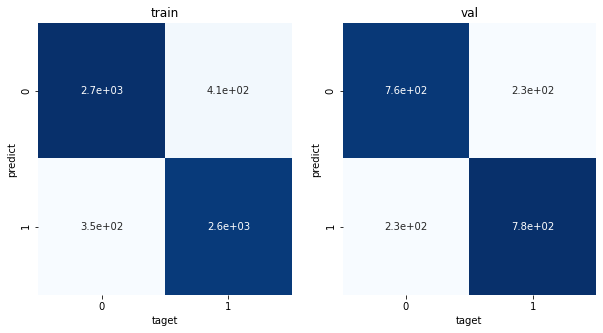

Index(['blueKills', 'blueDeaths__blueTotalGold', 'blueAssists__blueDragons',
       'blueKills__blueEliteMonsters', 'blueDeaths',
       'blueFirstBlood__blueDragons', 'blueDeaths__blueDragons',
       'blueAssists__blueEliteMonsters', 'blueDeaths__blueEliteMonsters',
       'blueKills/blueTotalExperience', 'blueFirstBlood__blueTotalExperience',
       'blueTotalExperience/blueEliteMonsters',
       'blueAssists__blueTotalExperience', 'blueTotalExperience/blueDragons',
       'blueKills/blueTotalGold', 'blueDeaths__blueTotalExperience',
       'blueKills__blueTotalExperience', 'blueKills/blueDeath',
       'blueTotalExperience'],
      dtype='object')


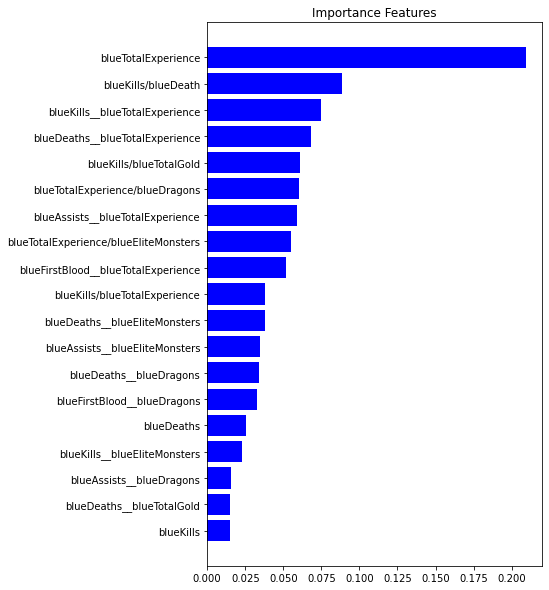

In [274]:
parameters = {'max_depth':[8,9,10,11], 'n_estimators':[2000,3000]}
clf = RandomForestClassifier()
cv = GridSearchCV(clf, parameters)
cv.fit(X_train, y_train)
clf = cv.best_estimator_
print("train:",clf.score(X_train,y_train))
print("test: ", clf.score(X_test,y_test))
print("best param: ",cv.best_params_)
print("importance: ",clf.feature_importances_)
y_train_pred = clf.predict(X_train).tolist()
y_test_pred = clf.predict(X_test).tolist()
Confusion_Matrix(train_true_li=y_train.tolist(),train_pred_li=y_train_pred,val_true_li=y_test.tolist(),val_pred_li=y_test_pred)


features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
print(features[indices])
plt.figure(figsize=(6,10))
plt.barh(range(len(importances)), importances[indices], color='b', align='center')
plt.yticks(range(len(importances)), features[indices])
plt.title('Importance Features')
plt.show()

# train: 0.7786666666666666
# test:  0.7505
# train: 0.783
# test:  0.7595

# train: 0.8476666666666667
# test:  0.769
# best param:  {'max_depth': 9, 'n_estimators': 2000}

In [ ]:
y_pred = clf.predict(z)
df_sub[1] = y_pred
df_sub.to_csv(BASE_DIR+'/subbmission.csv',header=None,index=False)

In [ ]:
gbm_param = {
    'learning_rate':[0.06,0.07,0.08,0.09],
    'n_estimators':[500,1000,2000],
    'num_leaves':[7,15],
    'max_depth':[4,5,6,7],
    'min_child_weight':[0.6,0.7,0.8],
    }
lgb_cv = GridSearchCV(lgb.LGBMClassifier(random_state=42), gbm_param,cv=5,scoring='roc_auc')
lgb_cv.fit(X_train,y_train)
print('trainデータのスコア{}'.format(lgb_cv.score(X_train, y_train)))
print('testデータのスコア{}'.format(lgb_cv.score(X_test, y_test)))
print("best_params:{}".format(lgb_cv.best_params_))
lgbc = lgb_cv.best_estimator_

y_train_pred = lgbc.predict(X_train).tolist()
y_test_pred = lgbc.predict(X_test).tolist()
Confusion_Matrix(train_true_li=y_train.tolist(),train_pred_li=y_train_pred,val_true_li=y_test.tolist(),val_pred_li=y_test_pred)

features = X_train.columns
importances = lgbc.feature_importances_
indices = np.argsort(importances)
print(features[indices])
plt.figure(figsize=(6,10))
plt.barh(range(len(importances)), importances[indices], color='b', align='center')
plt.yticks(range(len(importances)), features[indices])
plt.title('Importance Features')
plt.show()

In [277]:
y_test_pred = lgbc.predict(z).tolist()
df_sub[1] = y_test_pred
df_sub.to_csv(BASE_DIR+'/subbmission.csv',header=None,index=False)

In [160]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.7805


In [167]:
(y_pred==y_test).sum()/len(y_test)

0.7805

In [162]:
df_sub[1] = y_pred

In [72]:
pre = clf.predict(z)

In [73]:
df_sub[1] = pre

In [163]:
df_sub.to_csv(BASE_DIR+'/subbmission.csv',header=None,index=False)